# Trading Signal Features

---

### Import Libraries and Dependencies

In [24]:
import os
import pandas as pd
import numpy as np
import talib as ta
from pathlib import Path
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Download Securities Data via Alpaca API

In [25]:
# Load .env environment variables
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Format current date as ISO format
today = pd.Timestamp("2020-12-31", tz="America/New_York").isoformat()

# Set timeframe to one day ('1D') for the Alpaca API
timeframe = "1D"

# Set the tickers
tickers = ["AAPL", "MSFT", "AMZN", "FB", "TSLA", "SPY"]

In [26]:
start = pd.Timestamp("2020-01-08", tz="America/New_York").isoformat()
end = pd.Timestamp("2021-01-08", tz="America/New_York").isoformat()

df_portfolio = alpaca.get_barset(
    tickers,
    timeframe,
    start = start,
    end = end
).df

df_portfolio.index = df_portfolio.index.date
df_portfolio = df_portfolio.dropna()

In [27]:
# Create and empty DataFrame
df = pd.DataFrame()
df_aapl = pd.DataFrame()
df_msft = pd.DataFrame()
df_fb = pd.DataFrame()
df_tsla = pd.DataFrame()

# Fetch the prices 
df = df_portfolio["SPY"]
df_aapl = df_portfolio['AAPL']
df_msft = df_portfolio["MSFT"]
df_fb = df_portfolio["FB"]
df_tsla = df_portfolio["TSLA"]

### Drop NAs and Calculate Daily Returns 

In [28]:
# Drop NAs and calculate daily percent return
df['daily_return'] = df['close'].dropna().pct_change()
df_aapl['daily_return'] = df_aapl['close'].dropna().pct_change()
df_msft['daily_return'] = df_msft['close'].dropna().pct_change()
df_fb['daily_return'] = df_fb['close'].dropna().pct_change()
df_tsla['daily_return'] = df_tsla['close'].dropna().pct_change()

### Construct EMA (Trend Trading Signal)

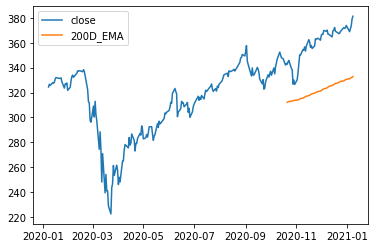

In [32]:
# Construct Exponential Moving Average from various windows
df['8D_EMA'] = ta.EMA(df['close'], timeperiod = 8)
df['21D_EMA'] = ta.EMA(df['close'], timeperiod = 21)
df['50D_EMA'] = ta.EMA(df['close'], timeperiod = 50)
df['200D_EMA'] = ta.EMA(df['close'], timeperiod = 200)

# Plot the EMAs
df[['close', '200D_EMA']].plot()

# Construct trading signals
df['8_21_x_long'] = np.where(df['8D_EMA'] > df['21D_EMA'], 1.0, 0.0)
df['8_21_x_short'] = np.where(df['8D_EMA'] < df['21D_EMA'], -1.0, 0.0)
df['8_21_x_signal'] = df['8_21_x_long'] + df['8_21_x_short']
df['21_50_x_long'] = np.where(df['21D_EMA'] > df['50D_EMA'], 1.0, 0.0)
df['21_50_x_short'] = np.where(df['21D_EMA'] < df['50D_EMA'], -1.0, 0.0)
df['21_50_x_signal'] = df['21_50_x_long'] + df['21_50_x_short']
df['50_200_x_long'] = np.where(df['50D_EMA'] > df['200D_EMA'], 1.0, 0.0)
df['50_200_x_short'] = np.where(df['50D_EMA'] < df['200D_EMA'], -1.0, 0.0)
df['50_200_x_signal'] = df['50_200_x_long'] + df['50_200_x_short']
df['above_8D'] = np.where(df['close'] > df['8D_EMA'], 1.0, 0.0)
df['above_21D'] = np.where(df['close'] > df['21D_EMA'], 1.0, 0.0)
df['above_50D'] = np.where(df['close'] > df['50D_EMA'], 1.0, 0.0)
df['above_200D'] = np.where(df['close'] > df['200D_EMA'], 1.0, 0.0)

### Construct Bollinger Band (BB Trading Signal)

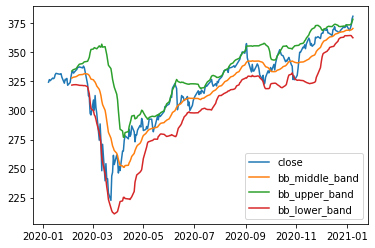

In [33]:
# Bollinger Bands
df['bb_upper_band'], df['bb_middle_band'], df['bb_lower_band'] = ta.BBANDS(df['close'], timeperiod =20)

# Plot the Bollinger Bands for BTC/USD closing prices
df[['close','bb_middle_band','bb_upper_band','bb_lower_band']].plot()

# Calculate bollinger band trading signal
df['bb_long'] = np.where(df['close'] < df['bb_lower_band'], 1.0, 0.0)
df['bb_short'] = np.where(df['close'] > df['bb_upper_band'], -1.0, 0.0)
df['bb_signal'] = df['bb_long'] + df['bb_short']

### Construct RSI

In [35]:
# Calculate RSI
df['RSI'] = ta.RSI(df['close'],14)

# Calculate RSI signal
df['rsi_ob'] = np.where(df['RSI'] > 70, 1.0, 0.0)
df['rsi_os'] = np.where(df['RSI'] < 30, 1.0, 0.0)

### Construct Stochastic Oscillators

In [39]:
df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# Calculate Stochastic Oscillators trading signal
df['slowk_x_long'] = np.where(df['slowk'] > df['slowd'], 1.0, 0.0)
df['slowk_x_short'] = np.where(df['slowk'] < df['slowd'], -1.0, 0.0)
df['slow_x_signal'] = df['slowk_x_long'] + df['slowk_x_short']

### ADX - Average Directional Movement Index

In [40]:
# Calculate ADX
df['adx'] = ta.ADX(df['high'], df['low'], df['close'], timeperiod=14)

# Calculate ADX signal
df['adx_strong'] = np.where(df['adx'] > 50, 1.0, 0.0)
df['adx_weak'] = np.where(df['adx'] < 20, 1.0, 0.0)

### OBV - On Balance Volume

In [42]:
df['obv'] = ta.OBV(df['close'], df['volume'])
df['obv_change']=df['obv'].pct_change()

# Calculate OBV signal
df['obv_increase'] = np.where(df['obv_change'] > 0, 1.0, 0.0)

### ADOSC - Chaikin A/D Oscillator

In [43]:
df['ADOSC'] = ta.ADOSC(df['high'], df['low'], df['close'], df['volume'], fastperiod=3, slowperiod=10)

# Calculate Chaikin A/D Oscillator signal
df['adosc_pos'] = np.where(df['ADOSC'] > 0, 1.0, 0.0)

### Average True Range

In [44]:
df['atr'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)

### List of All Features

In [48]:
df.dropna().head()

,open,high,low,close,volume,daily_return,8D_EMA,21D_EMA,50D_EMA,200D_EMA,...,slow_x_signal,adx,adx_strong,adx_weak,obv,obv_change,obv_increase,ADOSC,adosc_pos,atr
2020-10-21,343.33,345.67,342.40,342.690,46745662,-0.001893,344.261966,341.796502,337.285714,312.119083,...,-1.0,14.893459,0.0,1.0,292417334.0,-0.137827,0.0,-5.366863e+07,0.0,5.412656
2020-10-22,342.96,345.24,340.65,344.630,45094573,0.005661,344.343751,342.054093,337.573726,312.442575,...,1.0,14.207875,0.0,1.0,337511907.0,0.154213,1.0,-4.453164e+07,0.0,5.353895
2020-10-23,345.93,345.99,343.13,345.760,38718140,0.003279,344.658473,342.390994,337.894756,312.774091,...,1.0,13.407454,0.0,1.0,376230047.0,0.114716,1.0,-2.640748e+07,0.0,5.175760
2020-10-26,342.13,342.98,335.62,339.415,79491839,-0.018351,343.493257,342.120449,337.954373,313.039175,...,1.0,13.981956,0.0,1.0,296738208.0,-0.211285,0.0,-1.580197e+07,0.0,5.530348
2020-10-27,339.76,340.12,337.99,338.250,50634843,-0.003432,342.328089,341.768590,337.965967,313.290029,...,-1.0,14.515421,0.0,1.0,246103365.0,-0.170638,0.0,-2.220467e+07,0.0,5.287466
